In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")
sys.path.append("/home/mizworski/Repos/LightGBM/python-package/")
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.utils.validation import column_or_1d
from scipy import interp
from scipy import stats

In [2]:
import mlens
import lightgbm as lgb

[MLENS] backend: threading


In [3]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)
df.head()

,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,
38248,1939-11-30,retired,married,university.degree,no,yes,no,2009-10-19,cellular,2,999,1,failure,unknown
22394,1977-11-04,admin.,single,university.degree,no,yes,no,2008-08-08,cellular,4,999,0,nonexistent,unknown
14797,1963-07-19,management,married,high.school,unknown,no,no,2008-07-30,cellular,3,999,0,nonexistent,no
10904,1976-04-13,admin.,married,high.school,no,no,no,2008-06-25,telephone,1,999,0,nonexistent,no
544,1976-08-27,entrepreneur,single,university.degree,no,yes,no,2008-05-20,telephone,2,999,0,nonexistent,unknown


In [4]:
date_parse_format = '%Y-%m-%d'

def preprocess_data(data):
    now = datetime.strptime(data.contact_date.max(), date_parse_format)
#     data['sum_nan'] = (data[['default', 'loan', 'education', 'housing', 'job']] == 'unknown').sum(axis=1)
    data['age'] = data.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    data.drop('birth_date', axis=1, inplace=True)
#     data['contact_weekday'] = data.apply(lambda r: (datetime.strptime(r.contact_date, date_parse_format)).weekday(), axis=1)
    
#     data['age_range'] = data['age'].apply(age2class)
#     data.drop('age', axis=1, inplace=True)11
#     categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y']))

    categorical_cols = list(set(data.columns) - 
                            set(['birth_date', 'contact_date', 'campaign', 'previous','pdays', 'y','age', 'sum_nan']))
    X = pd.get_dummies(data, columns=categorical_cols)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    
    X['days_since_contact'] =  X.apply(lambda r: ((now - datetime.strptime(r.contact_date, date_parse_format)).days), 
                                       axis=1)
    
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
#     train_y = column_or_1d(train_y)
#     train_x = train_x.as_matrix()
#     test_x = test_x.as_matrix()
    
    return train_x, train_y, test_x
    

In [5]:

X_train, Y_train, X_test = preprocess_data(df.copy())

from sklearn.model_selection import RandomizedSearchCV
from numpy import random
from sklearn.preprocessing import PolynomialFeatures

In [6]:
X_train.columns

Index(['campaign', 'pdays', 'previous', 'age', 'default_no', 'default_unknown',
       'default_yes', 'contact_cellular', 'contact_telephone',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success',
       'housing_no', 'housing_unknown', 'housing_yes', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown', 'loan_no',
       'loan_unknown', 'loan_yes', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'contacted', 'days_since_contact'],
      dtype='object')

In [7]:
# df.education_1.value_counts()

In [8]:
X_train.head()

,campaign,pdays,previous,age,default_no,default_unknown,default_yes,contact_cellular,contact_telephone,poutcome_failure,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contacted,days_since_contact
id,,,,,,,,,,,,,,,,,,,,,
14797,3,999,0,47,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,853
10904,1,999,0,34,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,888
10824,1,999,0,33,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,909
8156,1,999,0,34,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,910
14519,5,999,0,30,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,875


In [9]:
from mlens.ensemble import Subsemble

In [10]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import  LogisticRegression, LinearRegression


In [36]:
def get_ensemble():
    model1 = [XGBClassifier(max_depth=4, gamma=3, reg_alpha=0.2137, min_child_weight=2, n_estimators=200,
                      reg_lambda=1, subsample=1, max_delta_step=5, learning_rate=0.006) for i in range(5)]

    model2 = [lgb.LGBMClassifier(nthread=4,silent=False, bagging_fraction= 0.8, bagging_freq= 16,
                                boosting_type= 'dart',colsample_bytree= 0.8,feature_fraction= 0.8,
                                is_unbalance= False, num_boosting_rounds=256
                               ) for i in range(10)]
 
    model3 = GradientBoostingClassifier(n_estimators=100)
    model4 = ExtraTreesClassifier(n_estimators=100)
    model5 = lgb.LGBMClassifier(nthread=4,silent=False)
    model6 = XGBClassifier()
    model7 = LogisticRegression()
    ensemble = Subsemble()

#     # # First layer
    ensemble.add(model1 + model2 + [model3], proba=True)
#     ensemble.add([LinearRegression() for i in range(6)])
#     ensemble.add([LinearRegression() for i in range(6)])
#     # # Second layer
#     ensemble.add([model3, model4], proba=True, shuffle=True)

    # # Final meta estimator
    ensemble.add_meta(LogisticRegression(), proba=True)
    
    return ensemble

In [37]:
# ensemble = get_ensemble()

# Train ensemble
# ensemble.fit(X, Y)

In [38]:
# ensemble.predict(X[test])

In [39]:
cv = StratifiedKFold(n_splits=5)

X = X_train.as_matrix()
Y = column_or_1d(Y_train)

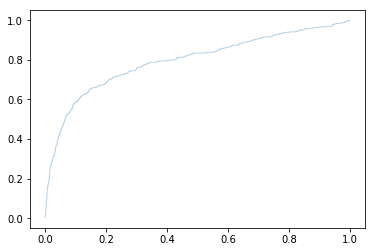

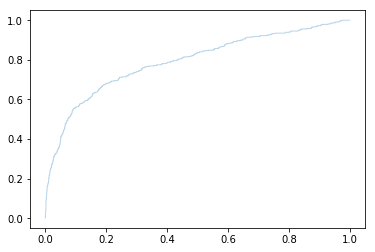

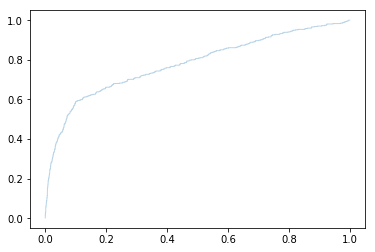

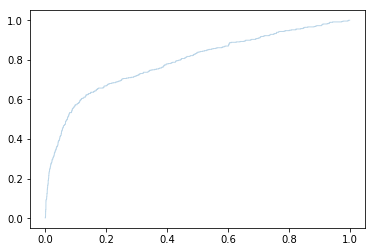

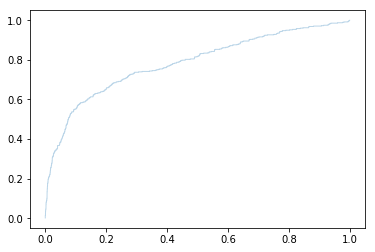

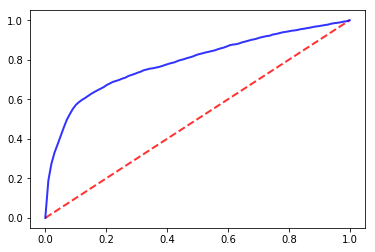

In [40]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0

for train, test in cv.split(X, Y):
    ensemble = get_ensemble()
    
    probas_ = ensemble.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.show()

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

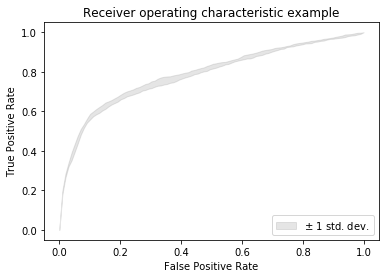

0.78774259014900727

In [41]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

mean_auc

In [42]:
ensemble = get_ensemble()
test_probs = ensemble.fit(X, Y).predict_proba(X_test.as_matrix())[:,1]

test_indices = X_test.index.values
results = pd.DataFrame({'id':test_indices, 'y':test_probs})
results_sorted = results.sort_values(['id'])
results_sorted.to_csv('ensemble2.csv', index=False)